# NNIA 18/19 Project 4:  Optimization \& Recurrent Neural Networks

## Deadline: 28. Februrary 2019, 23:59

In [1]:
# imports
%matplotlib notebook
import re
import math
import random
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['figure.figsize'] = (12.0, 8.0)

## 1. Optimization Algorithms$~$ (6 points)

In this task, we will get familiar with various optimization methods such as **Vanilla Gradient Descent** (GD), [**Gradient Descent with Momentum**](https://www.tensorflow.org/api_docs/python/tf/train/MomentumOptimizer), [**RMSProp**](https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer) and [**AdaGrad**](https://www.tensorflow.org/api_docs/python/tf/train/AdagradOptimizer) by implementing them in TensorFlow and *visualizing* the path (convergence) towards minima using [Matplotlib 3D/Contour plots](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html).

**3D Loss Surface**

For the following exercises we assume that the surface of the general **loss** we want to minimize is given by a function `z`. On this function, we apply different optimization methods and want to visualize their stepwise improvements. `z` is defined as:

$$ term1 = \frac{2}{\sqrt{(2\pi \alpha_{1}^{2})^{2}}} * \exp{\left(- \left[ \frac{(x-\mu_1)^2}{(\frac{\alpha {1}}{2})^2} + \frac{(y-\mu_1)^2}{(\alpha_1)^2}     \right] \right)} $$

$$ term2 = \frac{1}{\sqrt{(2\pi \alpha_{2}^{2})^{2}}} * \exp{\left(- \left[ \frac{(x-\mu_2)^2 + (y-\mu_2)^2}{(\alpha_2)^2} \right] \right)} $$

$$ term3 = \frac{1}{20} * \left(x^2  + xy + y^2 \right) $$ <br>

$$ z_{\alpha, \mu}(x, y) = term1 - term2 + term3 $$

To make yourself comfortable working with this function we provide a visualization by plotting it in 3D using [matplotlib-3D-wireframe](https://matplotlib.org/devdocs/gallery/mplot3d/wire3d.html). You can interactivaley play around with the plot to get familiar with the surface.

<IPython.core.display.Javascript object>


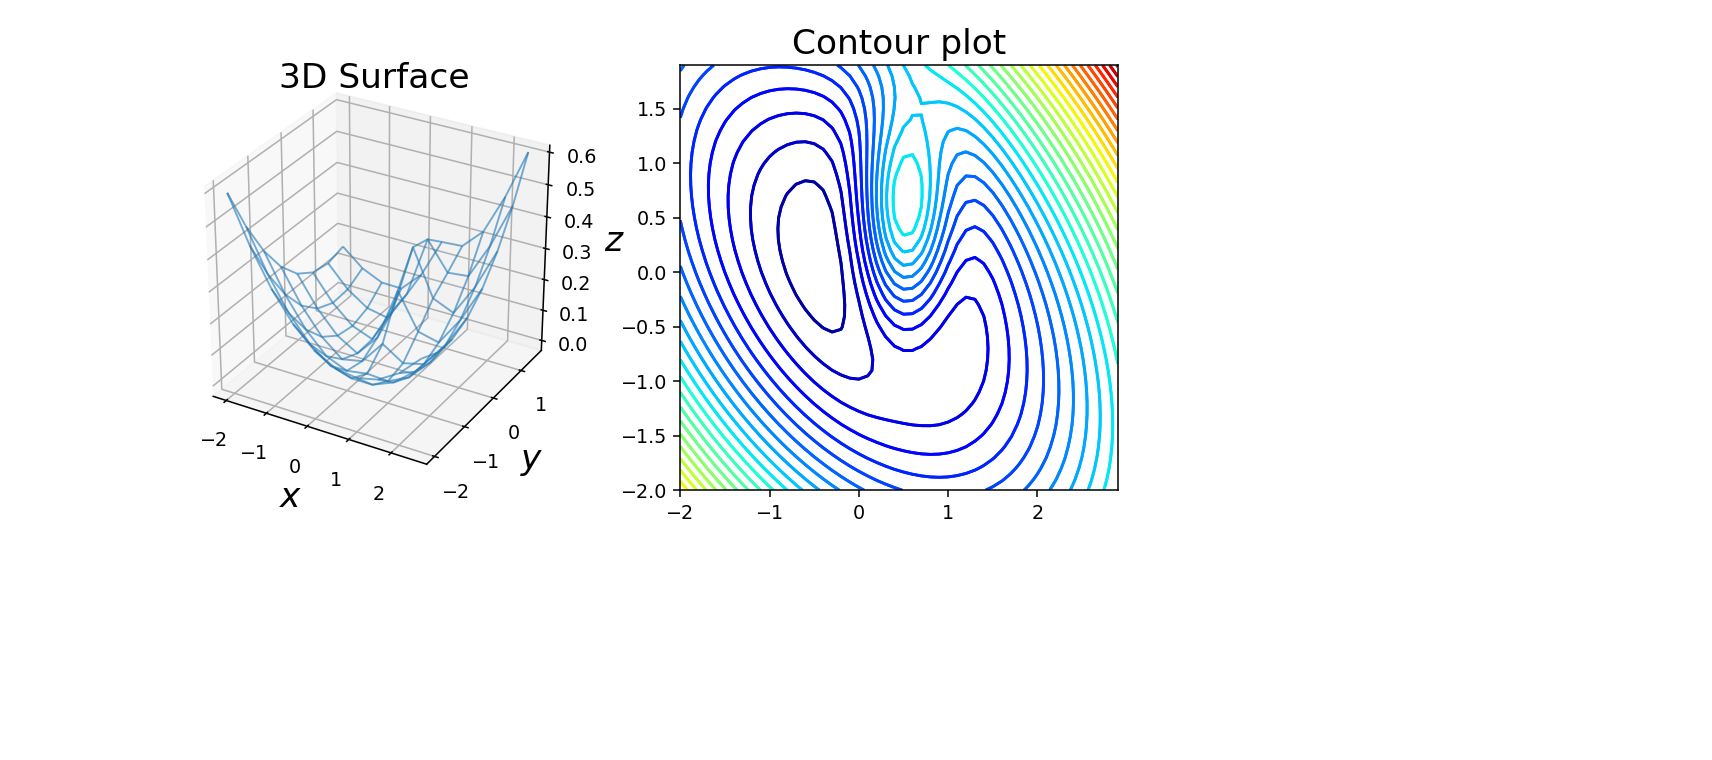

In [76]:
# %matplotlib inline

# params of our error surface `z`
alpha_1 = 1.0
alpha_2 = 2.0
mu_1 = 0.5
mu_2 = 0.0
range_x, range_y = np.arange(-2.0, 3.0, 0.5), np.arange(-2.0, 2.0, 0.5)

def func_z(X, Y):
    """
    function definition of our 3D error surface
    """
    exp_input_1 = -1 * ((((X - mu_1)**2) / (alpha_1/2)**2) + (((Y - mu_1)**2)/(alpha_1**2)))
    term_1 = 2/np.sqrt((2 * np.pi * alpha_1**2)**2) * np.exp(exp_input_1)
    
    exp_input_2 = -1 * ( ((X - mu_2)**2 + (Y - mu_2)**2) / alpha_2**2)
    term_2 = 1/np.sqrt((2 * np.pi * alpha_2**2)**2) * np.exp(exp_input_2)
    
    term_3 = 1/20 * (X**2 + X * Y + Y**2)
    
    return term_1 - term_2 + term_3

# x,y values for `Wireframe` plot
x_wireframe, y_wireframe = np.arange(-2.0, 3.0, 0.5), np.arange(-2.0, 2.0, 0.5)

# x,y values for `Contour` plot
x_contour, y_contour = np.arange(-2.0, 3.0, 0.1), np.arange(-2.0, 2.0, 0.1)

# Following code implements the plotting the Error Surface
X_sparse, Y_sparse = np.meshgrid(x_wireframe, y_wireframe)
Z_sparse = func_z(X_sparse, Y_sparse)

X_dense, Y_dense = np.meshgrid(x_contour, y_contour)
Z_dense = func_z(X_dense, Y_dense)

fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)

ax1.plot_wireframe(X_sparse, Y_sparse, Z_sparse, linewidth=1, cmap=cm.jet, zorder=1, alpha=0.6)
ax2.contour(X_dense, Y_dense, Z_dense, 32,  cmap=cm.jet)

ax1.set_xlabel(r'$x$',fontsize=18)
ax1.set_ylabel(r'$y$',fontsize=18)
ax1.set_zlabel(r'$z$',fontsize=18)
ax1.set_title('3D Surface', fontsize=18)

ax2.contour(X_dense, Y_dense, Z_dense, 32,  cmap=cm.jet)
ax2.autoscale(False)
ax2.set_title('Contour plot', fontsize=18)

plt.show()

### 1.1 Error Implementation with Tensorflow

Usually, we minimize the loss function of a neural network which is defined by a tensorflow computational graph which allows us perform optimization easily. Here, we first need to implement the 3D surface of the loss function described above using tensorflow. 

Setup the graph of the function by implementing `problem_3d` using tensorflow operations and variables. Write your code as specified by `# TODO`. (**1 point**)

In [104]:
# The following variables  will come in handy when implementing the error surface using tensorflow functions below
tf_x, tf_y, tf_z, = None, None, None
tf_reinit_x, tf_reinit_y = None, None
session = None

def problem_3d(start_x, start_y):
    global session
    global tf_x, tf_y, tf_z
    global tf_reinit_x, tf_reinit_y
    
    tf.reset_default_graph()
    session = tf.InteractiveSession()

    with tf.variable_scope('opt'):
        tf_x = tf.get_variable('x', initializer=tf.constant(start_x, shape=None, dtype=tf.float32))
        tf_y = tf.get_variable('y', initializer=tf.constant(start_y, shape=None, dtype=tf.float32))

    with tf.variable_scope('opt', reuse=True):
        tf_reinit_x = tf.assign(tf.get_variable('x'), start_x)
        tf_reinit_y = tf.assign(tf.get_variable('y'), start_y)
   
  
 

    exp_input_1 = -1 * ((((tf_x - mu_1)**2) / (alpha_1/2)**2) + (((tf_y - mu_1)**2)/(alpha_1**2)))
    tf_term_1 = 2/tf.sqrt((2 * math.pi * alpha_1**2)**2) * tf.exp(exp_input_1)
    
    exp_input_2 = -1 * ( ((tf_x - mu_2)**2 + (tf_y - mu_2)**2) / alpha_2**2)
    tf_term_2 = 1/np.sqrt((2 * math.pi * alpha_2**2)**2) * tf.exp(exp_input_2)
    
    tf_term_3 = 1/20 * (tf_x**2 + tf_x * tf_y + tf_y**2)
    tf_z = tf_term_1 - tf_term_2 + tf_term_3
    return tf_z


 

### 1.2 Implementation of Gradient Descent with Momentum

In the lecture chapter 8 on slide 20 you got introduced to an advanced implementation of the Gradient Descent Optimizer, called Gradient Descent with Momentum. In this exercise you should implement Gradient Descent with Momentum using tensorflow operations. 

In the following, we provide a class for GD with Momentum where you have to fill in the `#TODO` sections only. To get gradients of the objective you want to minimize, use the function [`tf.gradients`](https://www.tensorflow.org/api_docs/python/tf/gradients). Make sure, that your variables are always shaped correctly! (**2 points**).

In [105]:
class GradientDescentMomentumOptimizer():
    
    def __init__(self, learning_rate, alpha):

        with tf.variable_scope('gdm_opt'):
            self.learning_rate = tf.get_variable('lr', initializer=tf.constant(learning_rate, shape=[], dtype=tf.float32))
            self.alpha = tf.get_variable('alpha', initializer=tf.constant(alpha, shape=None, dtype=tf.float32))
            self.v = tf.get_variable('v', initializer=tf.constant([0, 0], shape=[2, 1], dtype=tf.float32))

        # input 
        self.input_x = tf.placeholder("float", [])
        self.input_y = tf.placeholder("float", [])

        # optimized outputs
        self.out_x = None
        self.out_y = None  

        # gradients
        self.grads = None

        # objective to minimize      
        self.objective = None
        
    def minimize(self, objective):
        self.objective = objective
        return self.optimization_step()

    def update(self, new_x, new_y, new_v):

        with tf.variable_scope('opt', reuse=True):
            tf_reinit_x = tf.assign(tf.get_variable('x'), new_x[0])
            tf_reinit_y = tf.assign(tf.get_variable('y'), new_y[0])

        with tf.variable_scope('gdm_opt', reuse=True):
            set_v =  tf.assign(tf.get_variable('v'), new_v)
            
        return tf_reinit_x, tf_reinit_y, set_v

    def optimization_step(self):
        
        global tf_x, tf_y   
        
        # TODO: Implement this function returning the updated positions into self.out_x, self.out_y
        self.grads=tf.gradients(self.objective,[tf_x,tf_y])
        #self.grads multipied with learning rate
        self.grads=tf.multiply(self.learning_rate,self.grads)
        self.grads=tf.reshape(self.grads,self.v.shape)
        #updating velocity 
        self.v= tf.multiply(alpha,self.v)-(self.grads)
        #self.v[0]= tf.multiply(self.alpha,self.v[0])-(self.grads[0])
        #self.v[1]= tf.multiply(self.alpha,self.v[1])-(self.grads[1])
        #updating thetas
        self.out_x=self.v[0]+tf_x
        self.out_y=self.v[1]+tf_y
        

        return self.out_x, self.out_y

In the following, use your implementation to find a local minimum in our loss function. We choose a fixed starting position and run the optimizer for a certain amount of steps.

In [108]:
# starting position
start_x, start_y = 0.55, 0.6
n_steps = 60

problem_3d(start_x,start_y)

lr = 0.1
alpha = 0.9

optimizer = GradientDescentMomentumOptimizer(lr, alpha)
opt_step = optimizer.minimize(objective=tf_z)

# initialize variables
session.run(tf.global_variables_initializer())

# set initial values
session.run([tf_reinit_x, tf_reinit_y])

# keep track of all steps
opt_gd_points_x, opt_gd_points_y, opt_gd_points_z = [],[],[]

# fill in the initial position
opt_gd_points_x.append(start_x)
opt_gd_points_y.append(start_y)
opt_gd_points_z.append(func_z(start_x,start_y))

x, y = [start_x], [start_y]

print('Momentum GD Optimization started')
for step in range(n_steps):

    # perform optimization step
    x, y, z, v, cur_gradient, _ = session.run([optimizer.out_x, optimizer.out_y, tf_z, optimizer.v, optimizer.grads, opt_step], feed_dict={optimizer.input_x: x[0], optimizer.input_y: y[0]}) 

    # update the function
    session.run([optimizer.update(x, y, v)])
    
    opt_gd_points_x.append(x[0])
    opt_gd_points_y.append(y[0])
    opt_gd_points_z.append(func_z(x[0], y[0]))
    
    if step % 10 == 0:
        print("Optimization step {} - minimized value: {}".format(step, z))
        #print(opt_gd_points_x)

Momentum GD Optimization started
Optimization step 0 - minimized value: 0.3279164135456085
Optimization step 10 - minimized value: 0.13208559155464172
Optimization step 20 - minimized value: 0.104763463139534
Optimization step 30 - minimized value: 0.0366252101957798
Optimization step 40 - minimized value: 0.04089508205652237
Optimization step 50 - minimized value: 0.04143727198243141


<IPython.core.display.Javascript object>


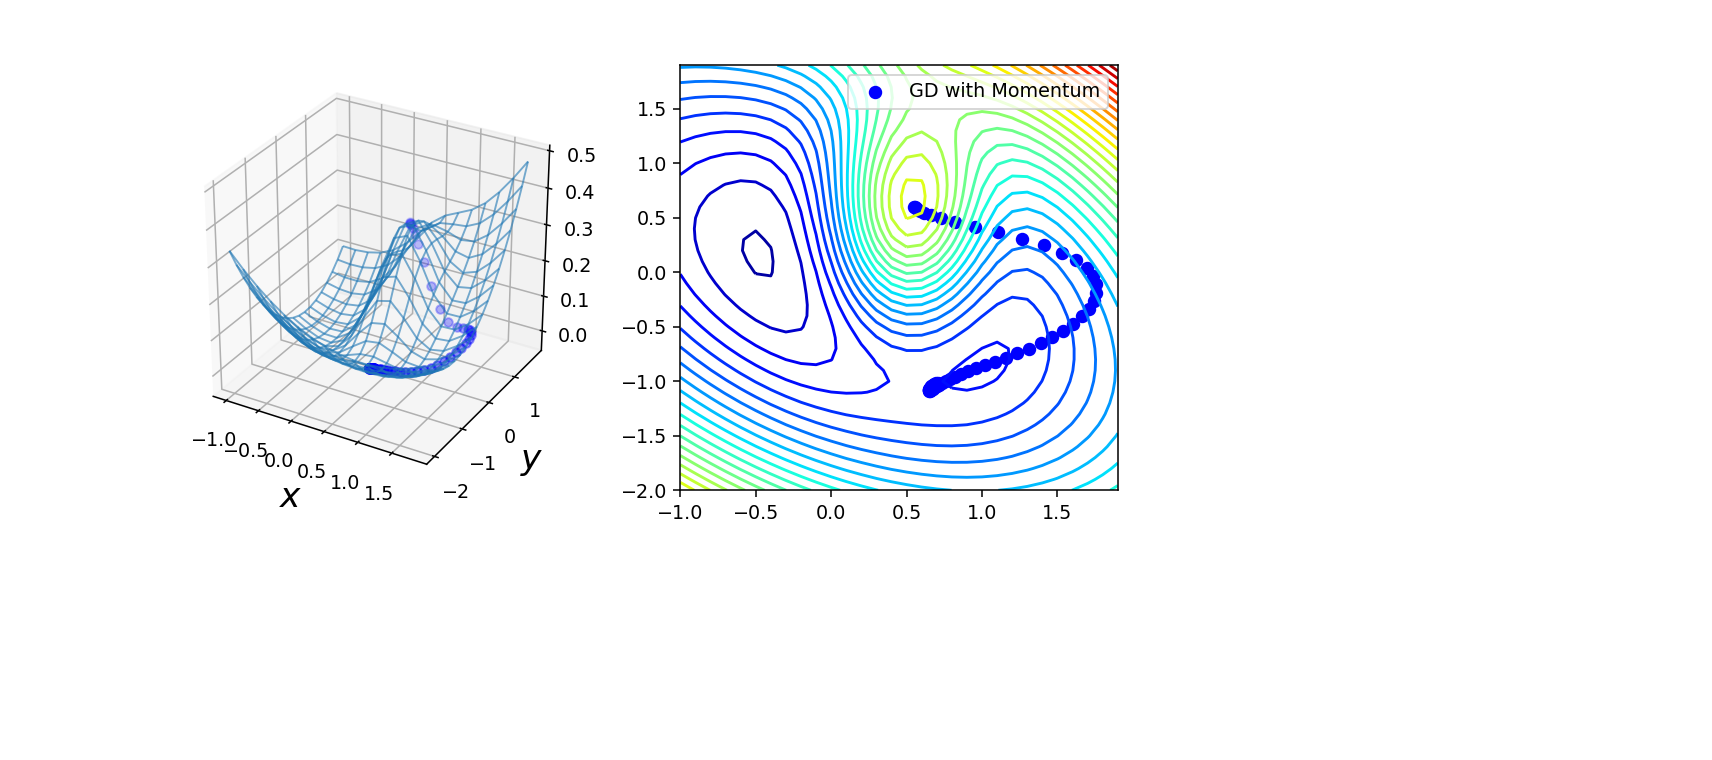

In [109]:
range_x,range_y = np.arange(-1.0,2.0,0.2), np.arange(-2.0,2.0,0.2)
X_lowres, Y_lowres = np.meshgrid(range_x, range_y)
Z_lowres = func_z(X_lowres,Y_lowres)

range_x,range_y = np.arange(-1.0,2.0,0.1), np.arange(-2.0,2.0,0.1)
X_hires, Y_hires = np.meshgrid(range_x, range_y)
Z_hires = func_z(X_hires,Y_hires)

fig = plt.figure(figsize=(9,4))

epsilon = 0.0
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)

# plot
ax1.plot_wireframe(X_lowres, Y_lowres, Z_lowres, linewidth=1, cmap=cm.jet, zorder=1, alpha=0.6)
ax2.contour(X_hires, Y_hires, Z_hires, 32,  cmap=cm.jet)
ax2.autoscale(False)

for idx, (x,y,z) in enumerate(zip(opt_gd_points_x, opt_gd_points_y, opt_gd_points_z)):
    if idx != len(opt_gd_points_x)-1:
        ax1.scatter(x,y,z + epsilon , color='blue', alpha=(idx+10)/(n_steps+10.0), zorder=100)
        ax2.scatter(np.asarray(x),np.asarray(y) , color='blue')
    else:
        ax1.scatter(x,y,z + epsilon , color='blue', alpha=(idx+10)/(n_steps+10.0), label='GD with Momentum', zorder=100)
        ax2.scatter(x,y, color='blue', label='GD with Momentum')

ax1.set_xlabel(r'$x$', fontsize=18)
ax1.set_ylabel(r'$y$', fontsize=18)
plt.legend()
plt.show()

Try out different combinations for the momentum scaler `alpha` and the learning rate `lr`. What are the impacts of these parameters? Does Momentum bring any benefit in this special example compared to GD without Momentum? - Briefly explain! (**1 point**).

### 1.3 Using Tensorflow's Optimizer Implementations

Tensorflow does of course provide optimizers which you do not have to implement explictly. In order to compare these different optimizers, complete the code below. Use the following implementations from the tensorflow library:

- [Gradient Descent](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer)
- [Gradient Descent with Momentum](https://www.tensorflow.org/api_docs/python/tf/train/MomentumOptimizer)
- [RMSProp](https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer) 
- [AdaGrad](https://www.tensorflow.org/api_docs/python/tf/train/AdagradOptimizer)

(**0.5 points**)


In [110]:
# starting position
start_x, start_y = 0.55, 0.6
n_steps = 60

# Write code to define GD, Momentum, RMSProp and Adagrad implementations on tf_z global variable defined by problem_3d

with tf.variable_scope('gd', reuse=tf.AUTO_REUSE):
    # TODO: Define Gradient Descent Optimizer with learning rate = 0.1
    tf_optimize_z = tf.train.GradientDescentOptimizer(0.1).minimize(tf_z)
    
with tf.variable_scope('momentum', reuse=tf.AUTO_REUSE):
    # TODO: Define Gradient Descent with Nestrov's Momentum Optimizer with learning rate = 0.1 and momentum = 0.9
    tf_mom_optimize_z = tf.train.MomentumOptimizer(learning_rate=0.1 ,momentum=0.9).minimize(tf_z)
    
with tf.variable_scope('rmsprop', reuse=tf.AUTO_REUSE):
    # TODO: Define RMSProp with learning rate = 0.1
    tf_rms_optimize_z = tf.train.RMSPropOptimizer(learning_rate=0.1).minimize(tf_z)
    
with tf.variable_scope('adagrad', reuse=tf.AUTO_REUSE):
    # TODO: Define Adagrad Optimizer with learning rate = 0.1
    tf_ada_optimize_z = tf.train.AdagradOptimizer(learning_rate=0.1).minimize(tf_z)
    

Vanilla GD Optimization started
Vanilla GD Optimization finished
Momentum Optimization started
Momentum Optimization finished
RMSProp Optimization started
RMSProp Optimization finished
Adagrad Optimization started
Adagrad Optimization finished


<IPython.core.display.Javascript object>


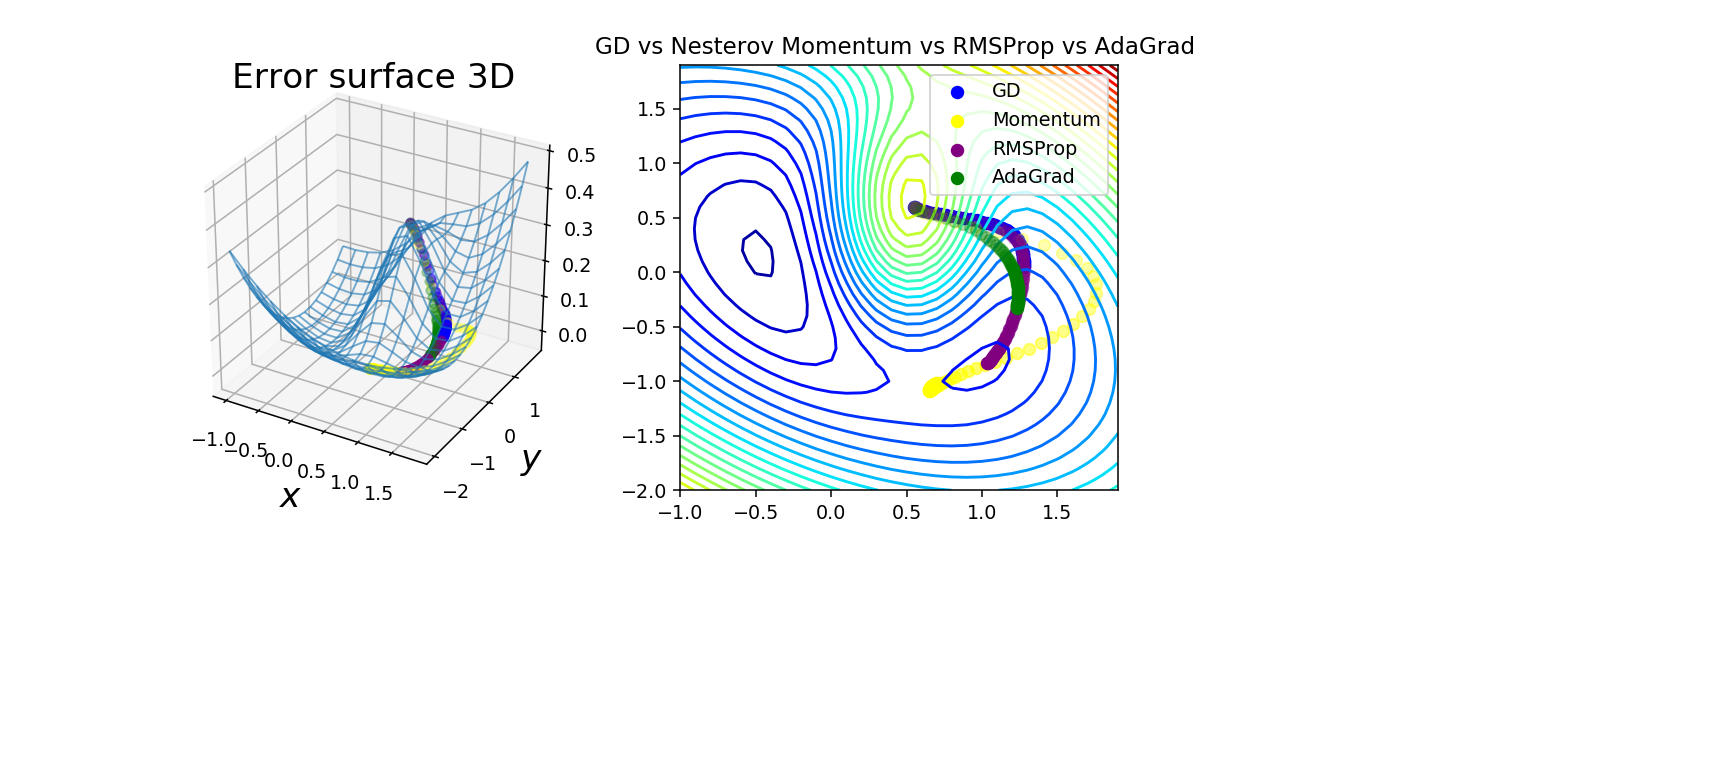

In [111]:
session.run(tf.global_variables_initializer())

# Run vanilla GD on Error Surface
session.run([tf_reinit_x, tf_reinit_y])

opt_gd_points_x, opt_gd_points_y, opt_gd_points_z = [],[],[]
opt_gd_points_x.append(start_x)
opt_gd_points_y.append(start_y)
opt_gd_points_z.append(func_z(start_x,start_y))

print('Vanilla GD Optimization started')
for step in range(n_steps):
    session.run(tf_optimize_z)
    x, y, z = session.run([tf_x, tf_y, tf_z])    
    opt_gd_points_x.append(x)
    opt_gd_points_y.append(y)
    opt_gd_points_z.append(z)
print('Vanilla GD Optimization finished')


# Run Nestrov's Momentum GD on Error Surface
session.run([tf_reinit_x, tf_reinit_y])

opt_mom_points_x, opt_mom_points_y, opt_mom_points_z = [],[],[]
opt_mom_points_x.append(start_x)
opt_mom_points_y.append(start_y)
opt_mom_points_z.append(func_z(start_x,start_y))


print("Momentum Optimization started")
for step in range(n_steps):
    session.run(tf_mom_optimize_z)
    x, y, z = session.run([tf_x, tf_y, tf_z])    
    opt_mom_points_x.append(x)
    opt_mom_points_y.append(y)
    opt_mom_points_z.append(z)
print('Momentum Optimization finished')
    
# RMSProp
session.run([tf_reinit_x, tf_reinit_y])

opt_rms_points_x, opt_rms_points_y, opt_rms_points_z = [],[],[]
opt_rms_points_x.append(start_x)
opt_rms_points_y.append(start_y)
opt_rms_points_z.append(func_z(start_x,start_y))

print('RMSProp Optimization started')
for step in range(n_steps):
    session.run(tf_rms_optimize_z)
    x, y, z = session.run([tf_x, tf_y, tf_z])    
    opt_rms_points_x.append(x)
    opt_rms_points_y.append(y)
    opt_rms_points_z.append(z)
print('RMSProp Optimization finished')


# Run AdaGrad on Error Surface
session.run([tf_reinit_x, tf_reinit_y])

opt_ada_points_x, opt_ada_points_y, opt_ada_points_z = [],[],[]
opt_ada_points_x.append(start_x)
opt_ada_points_y.append(start_y)
opt_ada_points_z.append(func_z(start_x,start_y))


print('Adagrad Optimization started')
for step in range(n_steps):
    session.run(tf_ada_optimize_z)
    x, y, z = session.run([tf_x, tf_y, tf_z])    
    opt_ada_points_x.append(x)
    opt_ada_points_y.append(y)
    opt_ada_points_z.append(z)
print('Adagrad Optimization finished')

    
range_x,range_y = np.arange(-1.0,2.0,0.2), np.arange(-2.0,2.0,0.2)
X_lowres, Y_lowres = np.meshgrid(range_x, range_y)
Z_lowres = func_z(X_lowres,Y_lowres)

range_x,range_y = np.arange(-1.0,2.0,0.1), np.arange(-2.0,2.0,0.1)
X_hires, Y_hires = np.meshgrid(range_x, range_y)
Z_hires = func_z(X_hires,Y_hires)

# Subplots visualizing the minimization steps

fig = plt.figure(figsize=(9,4))

epsilon = 0.0
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)

# plot
ax1.plot_wireframe(X_lowres, Y_lowres, Z_lowres, linewidth=1, cmap=cm.jet, zorder=1, alpha=0.6)
ax2.contour(X_hires, Y_hires, Z_hires, 32,  cmap=cm.jet)
ax2.autoscale(False)

# vanilla GD
for idx, (x,y,z) in enumerate(zip(opt_gd_points_x, opt_gd_points_y, opt_gd_points_z)):
    if idx != len(opt_gd_points_x)-1:
        ax1.scatter(x,y,z + epsilon , color='blue', alpha=(idx+10)/(n_steps+10.0), zorder=100)
        ax2.scatter(np.asarray(x),np.asarray(y) , color='blue')
    else:
        ax1.scatter(x,y,z + epsilon , color='blue', alpha=(idx+10)/(n_steps+10.0), label='GD', zorder=100)
        ax2.scatter(x,y, color='blue', label='GD')

# GD with momentum
for idx, (x,y,z) in enumerate(zip(opt_mom_points_x, opt_mom_points_y, opt_mom_points_z)):
    if idx != len(opt_mom_points_x)-1:
        ax1.scatter(x,y , z + epsilon , color='yellow', alpha=(idx+10)/(n_steps+10.0), zorder=100)
        ax2.scatter(x,y , color='yellow', alpha=(idx+10)/(n_steps+10.0))
    else:
        ax1.scatter(x,y,z + epsilon , color='yellow', alpha=(idx+10)/(n_steps+10.0), label='Momentum', zorder=100)
        ax2.scatter(x,y, color='yellow', alpha=(idx+10)/(n_steps+10.0), label='Momentum')

# RMSProp
for idx, (x,y,z) in enumerate(zip(opt_rms_points_x, opt_rms_points_y, opt_rms_points_z)):
    if idx != len(opt_rms_points_x)-1:
        ax1.scatter(x,y,z + epsilon , color='purple', alpha=(idx+10)/(n_steps+10.0), zorder=100)
        ax2.scatter(x,y , color='purple', alpha=(idx+10)/(n_steps+10.0))
    else:
        ax1.scatter(x,y,z + epsilon , color='purple', alpha=(idx+10)/(n_steps+10.0), label='RMSProp', zorder=100)
        ax2.scatter(x,y, color='purple', alpha=(idx+10)/(n_steps+10.0), label='RMSProp')
        
# AdaGrad
for idx, (x,y,z) in enumerate(zip(opt_ada_points_x, opt_ada_points_y, opt_ada_points_z)):
    if idx != len(opt_ada_points_x)-1:
        ax1.scatter(x,y,z + epsilon , color='green', alpha=(idx+10)/(n_steps+10.0), zorder=100)
        ax2.scatter(x,y , color='green', alpha=(idx+10)/(n_steps+10.0), zorder=100)
    else:
        ax1.scatter(x,y,z + epsilon , color='green', alpha=(idx+10)/(n_steps+10.0), label='AdaGrad', zorder=100)
        ax2.scatter(x,y,color='green', alpha=(idx+10)/(n_steps+10.0), label='AdaGrad', zorder=100)

ax1.set_xlabel(r'$x$', fontsize=18)
ax1.set_ylabel(r'$y$', fontsize=18)
ax1.set_title("Error surface 3D", fontsize=18)
ax2.set_title('GD vs Nesterov Momentum vs RMSProp vs AdaGrad ', fontsize=12)
plt.legend()
plt.show()

Evaluate the function `z` at the termination points for each algorithm from the plots above. Which algorithm has made better progress in minimizing `z`?. Is it generally good to  always use this method? Briefly explain your findings. (**1.5 points**)